# <center> Trabajo Practico N2: Redes Recurrentes </center>
<div>
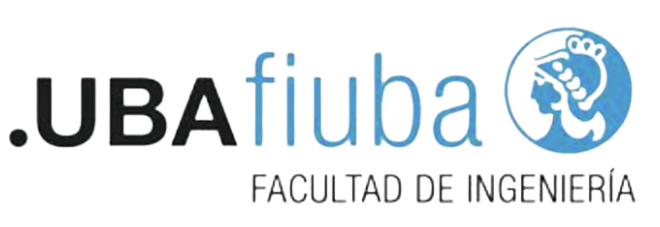
</div>

### <center>José Mornaghi y Lucas Argento</center>

Utilizando como base los scripts stock_prediction.ipynb, vamos a crear una RNN y LSTM que sea capaz de predecir el precio futuro del BTC en USD.

In [7]:
# Fuente: https://finance.yahoo.com/quote/BTC-USD/history?period1=1535760000&period2=1661990400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
df = pd.read_csv('Datasets/BTC-USD.csv')

In [8]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-09-01,7044.810059,7242.290039,7038.049805,7193.250000,7193.250000,4116050000
1,2018-09-02,7189.580078,7306.310059,7132.160156,7272.720215,7272.720215,4329540000
2,2018-09-03,7279.029785,7317.939941,7208.149902,7260.060059,7260.060059,4087760000
3,2018-09-04,7263.000000,7388.259766,7255.439941,7361.660156,7361.660156,4273640000
4,2018-09-05,7361.459961,7388.430176,6792.830078,6792.830078,6792.830078,5800460000
...,...,...,...,...,...,...,...
1457,2022-08-28,20041.035156,20139.054688,19616.814453,19616.814453,19616.814453,24366810591
1458,2022-08-29,19615.154297,20357.462891,19600.785156,20297.994141,20297.994141,32637854078
1459,2022-08-30,20298.611328,20542.644531,19617.640625,19796.808594,19796.808594,34483360283
1460,2022-08-31,19799.582031,20420.990234,19799.582031,20049.763672,20049.763672,33225232872


Text(0.5, 1.0, 'BTC Price Time Series')

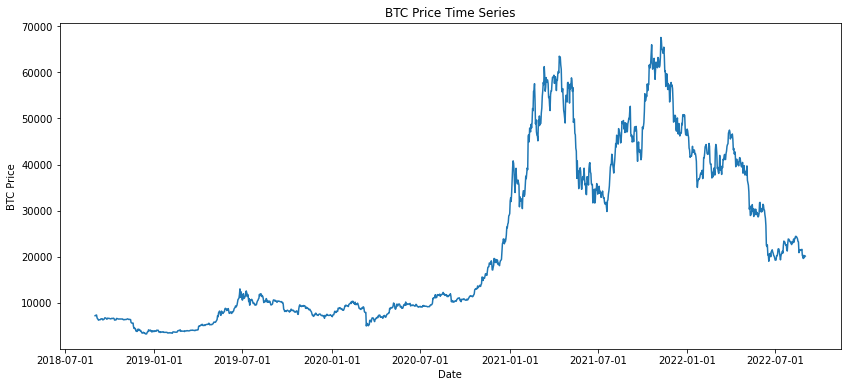

In [9]:
import matplotlib.dates as mdates
import datetime

fmt = mdates.DateFormatter('%Y-%m-%d')
x_date = [datetime.datetime.strptime(i, '%Y-%m-%d') for i in df.Date]

fig, ax = plt.subplots(figsize=(14, 6))

plt.plot(x_date, df.Close)
plt.xticks(rotation=0)
ax.xaxis.set_major_formatter(fmt)

plt.xlabel('Date')
plt.ylabel('BTC Price');
plt.title("BTC Price Time Series")


### A) Hacer split del dataset en entrenamiento/test.

> Para no incurrer en Data Leakeage, se deberia splitear el dataset previo a realizar data wrangling (normalizacion/scaling). Explicación sobre el concepto de Data Leakage: https://machinelearningmastery.com/data-leakage-machine-learning/

**_Split en sets de entrenamiento, validación y testeo_**

In [10]:
def split_data(price, lookback):
    data_raw = price.to_numpy()
    data = []
    
    # se crean todas las posibles secuencias de la longitud de la secuencia
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    print(data)
    # 20% para set de testeo, el 80% para entrenamiento
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    # X son los valores anteriores (en un deltaT = lookback) e Y es el valor actual a predecir.
    
    # Train set
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    # Test set 
    x_test = data[train_set_size:,:-1,:]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test, data]

# Longitud de secuencia de los datos 
lookback = 5

# definimos la variable a predecir
price = df[['Close']]

# Splitted dataset
x_train, y_train, x_test, y_test, data = split_data(price, lookback)

# shape checking
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

[[[ 7193.25    ]
  [ 7272.720215]
  [ 7260.060059]
  [ 7361.660156]
  [ 6792.830078]]

 [[ 7272.720215]
  [ 7260.060059]
  [ 7361.660156]
  [ 6792.830078]
  [ 6529.169922]]

 [[ 7260.060059]
  [ 7361.660156]
  [ 6792.830078]
  [ 6529.169922]
  [ 6467.069824]]

 ...

 [[21600.904297]
  [20260.019531]
  [20041.738281]
  [19616.814453]
  [20297.994141]]

 [[20260.019531]
  [20041.738281]
  [19616.814453]
  [20297.994141]
  [19796.808594]]

 [[20041.738281]
  [19616.814453]
  [20297.994141]
  [19796.808594]
  [20049.763672]]]
(1166, 4, 1)
(291, 4, 1)
(1166, 1)
(291, 1)


**_Scaling_**

> Custom 3d scaler for X data and simple 2d scaler for y data

In [11]:
class MinMaxScaler3D(MinMaxScaler):

    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)

In [12]:
myscaler = MinMaxScaler3D(feature_range=(-1, 1))

# scalling de ambos sets: train set
x_train = myscaler.fit_transform(x_train)

# test set
x_test = myscaler.fit_transform(x_test)

print("Dimensions post scaling: ", "\nx_train: ",x_train.shape,"\ny_train: ",y_train.shape,"\nx_test: ",x_test.shape,"\ny_test: ",y_test.shape)

Dimensions post scaling:  
x_train:  (1166, 4, 1) 
y_train:  (1166, 1) 
x_test:  (291, 4, 1) 
y_test:  (291, 1)


In [13]:
scaler = MinMaxScaler(feature_range=(-1, 1))

# escalamos para train y test por separado hay que cambiar a logica numpy
y_train = scaler.fit_transform(y_train.reshape(-1,1))

# escalamos para test set
y_test = scaler.fit_transform(y_test.reshape(-1,1))

In [14]:
# shape checking
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1166, 4, 1)
(291, 4, 1)
(1166, 1)
(291, 1)


In [15]:
x_train

array([[[-0.87699412],
        [-0.87452342],
        [-0.87491702],
        [-0.8717583 ]],

       [[-0.87452342],
        [-0.87491702],
        [-0.8717583 ],
        [-0.88944304]],

       [[-0.87491702],
        [-0.8717583 ],
        [-0.88944304],
        [-0.89764014]],

       ...,

       [[ 0.86818481],
        [ 1.        ],
        [ 0.98150165],
        [ 0.9200499 ]],

       [[ 1.        ],
        [ 0.98150165],
        [ 0.9200499 ],
        [ 0.91864248]],

       [[ 0.98150165],
        [ 0.9200499 ],
        [ 0.91864248],
        [ 0.89395669]]])

In [16]:
# convertimos a tensores de torch

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)

x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

In [17]:
x_train.size()

torch.Size([1166, 4, 1])

### B) Modificar con diferentes valores la dimensión del vector de la secuencia de entrada, la cantidad de capas, número de features en el estado oculto. Explicar que sucede y en que caso es conveniente un valor mayor o menor

In [18]:
RNN_0 = crear_modelo("RNN", input_dim = 1, hidden_dim = 64 , num_layers = 2, output_dim = 1, dropout_prob = 0)

In [19]:
loss_RNN = entrenar_modelo("RNN", RNN_0, x_train,  y_train, learning_rate = 0.001, num_epochs = 100) # corre ful rapido

Epoch  0 MSE:  0.44239407777786255
Epoch  1 MSE:  0.36707574129104614
Epoch  2 MSE:  0.3099311590194702
Epoch  3 MSE:  0.2696613073348999
Epoch  4 MSE:  0.2443544864654541
Epoch  5 MSE:  0.22893373668193817
Epoch  6 MSE:  0.21508273482322693
Epoch  7 MSE:  0.1962973177433014
Epoch  8 MSE:  0.17139692604541779
Epoch  9 MSE:  0.14321216940879822
Epoch  10 MSE:  0.11574412137269974
Epoch  11 MSE:  0.09199288487434387
Epoch  12 MSE:  0.0726371482014656
Epoch  13 MSE:  0.055791739374399185
Epoch  14 MSE:  0.0387294702231884
Epoch  15 MSE:  0.021118083968758583
Epoch  16 MSE:  0.0069279358722269535
Epoch  17 MSE:  0.002514864318072796
Epoch  18 MSE:  0.009495333768427372
Epoch  19 MSE:  0.018897514790296555
Epoch  20 MSE:  0.023172536864876747
Epoch  21 MSE:  0.025225484743714333
Epoch  22 MSE:  0.028472397476434708
Epoch  23 MSE:  0.028996475040912628
Epoch  24 MSE:  0.023518582805991173
Epoch  25 MSE:  0.01509547233581543
Epoch  26 MSE:  0.008433022536337376
Epoch  27 MSE:  0.0052959602326

### C) Dibujar la curva de la función costo en funcion de los pasos de entrenamiento

Text(0.5, 1.0, 'Loss RNN vs Training Steps')

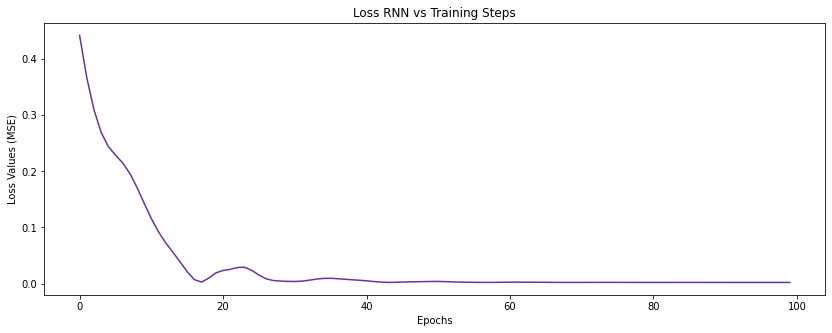

In [20]:
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(loss_RNN, c='rebeccapurple')
plt.xlabel('Epochs')
plt.ylabel('Loss Values (MSE)')
plt.title("Loss RNN vs Training Steps")

### D) Comprar el entrenamiento de una RNN y LSTM

In [21]:
LSTM_0 = crear_modelo("LSTM", input_dim = 1, hidden_dim = 64 , num_layers = 2, output_dim = 1, dropout_prob = 0)

In [22]:
loss_LSTM = entrenar_modelo("LSTM", LSTM_0, x_train,  y_train, learning_rate = 0.001, num_epochs = 100) # corre full rapido

Epoch  0 MSE:  0.6716415286064148
Epoch  1 MSE:  0.6453490257263184
Epoch  2 MSE:  0.6192495226860046
Epoch  3 MSE:  0.5932414531707764
Epoch  4 MSE:  0.5672330856323242
Epoch  5 MSE:  0.541133463382721
Epoch  6 MSE:  0.5148497819900513
Epoch  7 MSE:  0.48828843235969543
Epoch  8 MSE:  0.4613724946975708
Epoch  9 MSE:  0.4340633749961853
Epoch  10 MSE:  0.40638232231140137
Epoch  11 MSE:  0.37843212485313416
Epoch  12 MSE:  0.3504246473312378
Epoch  13 MSE:  0.32271745800971985
Epoch  14 MSE:  0.29585808515548706
Epoch  15 MSE:  0.27063170075416565
Epoch  16 MSE:  0.2480958253145218
Epoch  17 MSE:  0.22956018149852753
Epoch  18 MSE:  0.21642373502254486
Epoch  19 MSE:  0.20972061157226562
Epoch  20 MSE:  0.20928673446178436
Epoch  21 MSE:  0.21294263005256653
Epoch  22 MSE:  0.2167946696281433
Epoch  23 MSE:  0.2170967310667038
Epoch  24 MSE:  0.2120562344789505
Epoch  25 MSE:  0.20209722220897675
Epoch  26 MSE:  0.18900060653686523
Epoch  27 MSE:  0.17488661408424377
Epoch  28 MSE:  0

Text(0.5, 1.0, 'Loss LSTM vs RNN Training Steps')

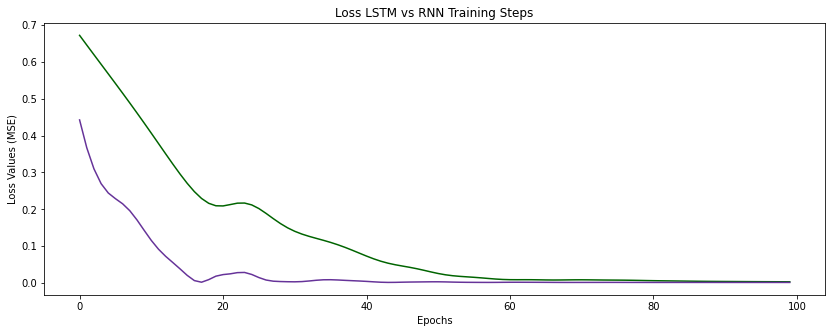

In [23]:
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(loss_LSTM, c='darkgreen')
plt.plot(loss_RNN, c = "rebeccapurple")
plt.xlabel('Epochs')
plt.ylabel('Loss Values (MSE)')
plt.title("Loss LSTM vs RNN Training Steps")

In [24]:
LSTM_1 = crear_modelo("LSTM", input_dim = 1, hidden_dim = 64 , num_layers = 2, output_dim = 1, dropout_prob = 0)
loss_LSTM_1 = entrenar_modelo("LSTM", LSTM_1, x_train,  y_train, learning_rate = 0.001, num_epochs = 150) # corre full rapido

Epoch  0 MSE:  0.5978657603263855
Epoch  1 MSE:  0.577504575252533
Epoch  2 MSE:  0.5573599338531494
Epoch  3 MSE:  0.5373190641403198
Epoch  4 MSE:  0.5172473192214966
Epoch  5 MSE:  0.49702006578445435
Epoch  6 MSE:  0.476523756980896
Epoch  7 MSE:  0.45566391944885254
Epoch  8 MSE:  0.43437421321868896
Epoch  9 MSE:  0.4126216471195221
Epoch  10 MSE:  0.39041614532470703
Epoch  11 MSE:  0.3678247630596161
Epoch  12 MSE:  0.3449932634830475
Epoch  13 MSE:  0.32217395305633545
Epoch  14 MSE:  0.29976046085357666
Epoch  15 MSE:  0.2783261835575104
Epoch  16 MSE:  0.25865617394447327
Epoch  17 MSE:  0.24174724519252777
Epoch  18 MSE:  0.22872385382652283
Epoch  19 MSE:  0.22056375443935394
Epoch  20 MSE:  0.21750999987125397
Epoch  21 MSE:  0.21831457316875458
Epoch  22 MSE:  0.2201015204191208
Epoch  23 MSE:  0.2195771187543869
Epoch  24 MSE:  0.214737668633461
Epoch  25 MSE:  0.20552460849285126
Epoch  26 MSE:  0.19327734410762787
Epoch  27 MSE:  0.17982220649719238
Epoch  28 MSE:  0.

Text(0.5, 1.0, 'Loss LSTM vs Training Steps')

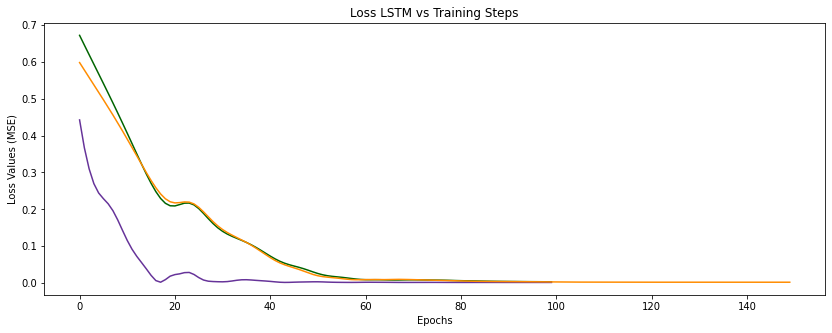

In [25]:
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(loss_LSTM, c='darkgreen')
plt.plot(loss_RNN, c = "rebeccapurple")
plt.plot(loss_LSTM_1, c='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss Values (MSE)')
plt.title("Loss LSTM vs Training Steps")

### E) ¿Qué metricas utilizaría para hacer una comparación objetiva entre la performance de cada modelo (RNN vs LSTM)?

El Mean Square Error mide la diferencia entre el valor real y el valor que predecimos. Creemos que como performance input tiene mucha logica.

> Vamos a realizar las predicciones con ambos modelos.

**Prediccion RNN** sobre train dataset

In [26]:
RNN_0.eval()
# para mandar al modelo a predecir
h0 = torch.zeros(RNN_0.num_layers, 5, RNN_0.hidden_dim).requires_grad_()

x_train = x_train.float()
h0 = h0.float()

# realizar predicciones con el modelo, sobre el dataset de entrenamiento
with torch.inference_mode():
  y_preds_over_train,h0 = RNN_0(x_train,h0)
y_preds_over_train.numpy()

array([[-0.87209773],
       [-0.874892  ],
       [-0.88109463],
       ...,
       [ 0.9043944 ],
       [ 0.9074191 ],
       [ 0.8877765 ]], dtype=float32)

In [27]:
y_preds = np.array(y_preds_over_train)
y_train = np.array(y_train)
dataset = pd.DataFrame(np.hstack((y_preds, y_train.reshape(-1, 1))))
dataset.rename(columns = {0:'y_preds',1:'y_train'})

,y_preds,y_train
0,-0.872098,-0.889443
1,-0.874892,-0.897640
2,-0.881095,-0.899571
3,-0.887334,-0.907066
4,-0.894771,-0.904738
...,...,...
1161,0.847304,0.981502
1162,0.887527,0.920050
1163,0.904394,0.918642
1164,0.907419,0.893957


Text(0.5, 1.0, 'RNN results over training dataset')

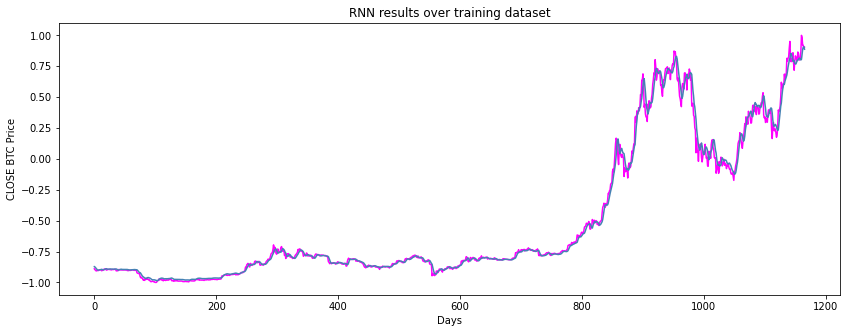

In [28]:
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(y_train, c='magenta')
plt.plot(y_preds_over_train, c = 'steelblue')
plt.xlabel('Days')
plt.ylabel('CLOSE BTC Price')
plt.title("RNN results over training dataset")

**RNN predicción** sobre test dataset

In [29]:
h0 = torch.zeros(RNN_0.num_layers, 5, RNN_0.hidden_dim).requires_grad_()
h0 = h0.float()
x_test = x_test.float()

# realizar predicciones con el modelo, sobre el dataset de testeo
with torch.inference_mode():
  y_preds_over_test,h0 = RNN_0(x_test,h0)
y_preds_over_test.numpy()

array([[ 9.16751385e-01],
       [ 9.21975613e-01],
       [ 9.12224412e-01],
       [ 8.73349905e-01],
       [ 8.31972420e-01],
       [ 7.60345221e-01],
       [ 7.10482955e-01],
       [ 7.08581865e-01],
       [ 7.01339483e-01],
       [ 6.91375971e-01],
       [ 6.79498613e-01],
       [ 6.51369929e-01],
       [ 6.38874769e-01],
       [ 6.12806618e-01],
       [ 5.81023932e-01],
       [ 5.90910137e-01],
       [ 6.06444001e-01],
       [ 6.38844728e-01],
       [ 6.56576455e-01],
       [ 6.48855448e-01],
       [ 6.08491838e-01],
       [ 5.26590765e-01],
       [ 4.39668179e-01],
       [ 3.82799625e-01],
       [ 3.62136155e-01],
       [ 3.76187325e-01],
       [ 3.57173502e-01],
       [ 3.15836847e-01],
       [ 2.99239218e-01],
       [ 3.03586662e-01],
       [ 2.98138350e-01],
       [ 2.80956089e-01],
       [ 2.72332281e-01],
       [ 2.57234424e-01],
       [ 2.50496328e-01],
       [ 2.45354712e-01],
       [ 2.24701047e-01],
       [ 2.18408972e-01],
       [ 2.4

Text(0.5, 1.0, 'RNN results over testing dataset')

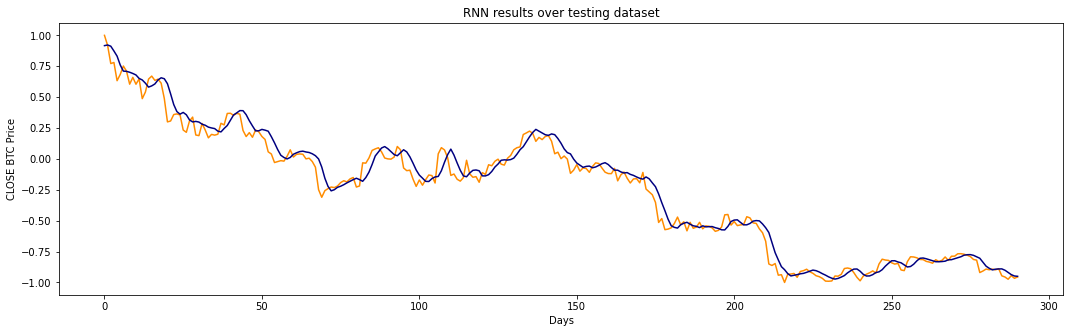

In [30]:
fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(y_test, c='darkorange')
plt.plot(y_preds_over_test, c = 'navy')
plt.xlabel('Days')
plt.ylabel('CLOSE BTC Price')
plt.title("RNN results over testing dataset")

**LSTM** sobre el test dataset

In [31]:
LSTM_1.eval()

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [32]:
x_test = x_test.float()

# realizar predicciones con el modelo, sobre el dataset de testeo
with torch.inference_mode():
  y_preds_over_test_LSTM = LSTM_1(x_test)
y_preds_over_test_LSTM.numpy()

array([[ 0.88744617],
       [ 0.8846625 ],
       [ 0.87952524],
       [ 0.8706943 ],
       [ 0.8442433 ],
       [ 0.7806832 ],
       [ 0.72198355],
       [ 0.7028048 ],
       [ 0.6801372 ],
       [ 0.695877  ],
       [ 0.6922437 ],
       [ 0.6582848 ],
       [ 0.6343623 ],
       [ 0.6303184 ],
       [ 0.5999591 ],
       [ 0.5906224 ],
       [ 0.57637745],
       [ 0.6221263 ],
       [ 0.6549356 ],
       [ 0.65228224],
       [ 0.62737614],
       [ 0.58123434],
       [ 0.50004786],
       [ 0.40945873],
       [ 0.35664585],
       [ 0.3751718 ],
       [ 0.3800788 ],
       [ 0.35106415],
       [ 0.31674752],
       [ 0.29052234],
       [ 0.30283526],
       [ 0.3131574 ],
       [ 0.28967157],
       [ 0.25088438],
       [ 0.2607116 ],
       [ 0.2692426 ],
       [ 0.23538895],
       [ 0.22033417],
       [ 0.2406614 ],
       [ 0.25917473],
       [ 0.29712525],
       [ 0.34537062],
       [ 0.3673255 ],
       [ 0.39859408],
       [ 0.3967999 ],
       [ 0

Text(0.5, 1.0, 'LSTM results over testing dataset')

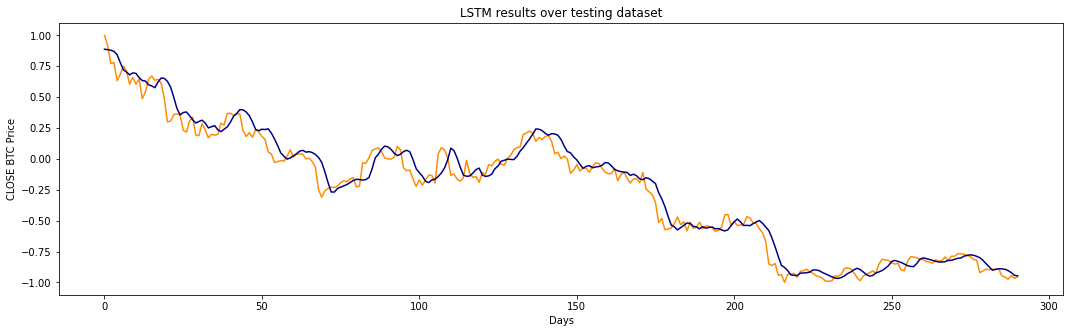

In [33]:
fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(y_test, c='darkorange')
plt.plot(y_preds_over_test_LSTM, c = 'navy')
#plt.plot(y_preds_over_test, c = 'green')
plt.xlabel('Days')
plt.ylabel('CLOSE BTC Price')
plt.title("LSTM results over testing dataset")

### Prediccion real de valores futuros del BTC 

> Queres predecir el valor del BTC de los proximos 10 dias, a partir de toda la secuencia anterior.


In [34]:
# definimos la variable a predecir
price = df[['Close']]

# Longitud de secuencia de los datos 
lookback = len(price) - 10
#print("training over a sequence of: ", lookback, "examples")

data_raw = price.to_numpy()
#print("dataraw", data_raw)
data = []
#print(len(data_raw))

# se crean todas las posibles secuencias de la longitud de la secuencia
for index in range(len(data_raw) - lookback): 
    data.append(data_raw[index: index + lookback])

data = np.array(data);
print(data.shape)
# 20% para set de testeo, el 80% para entrenamiento
test_set_size = int(np.round(0.2*data.shape[0]));
train_set_size = data.shape[0] - (test_set_size);

# X son los valores anteriores (en un deltaT = lookback) e Y es el valor actual a predecir.

# Train set
x_train = data[:train_set_size,:-1,:]
y_train = data[:train_set_size,-1,:]

# Test set 
x_test = data[train_set_size:,:-1,:]
y_test = data[train_set_size:,-1,:]

print(x_train.shape)
print(y_train.shape)
print(y_train)

(10, 1452, 1)
(8, 1451, 1)
(8, 1)
[[21398.908203]
 [21528.087891]
 [21395.019531]
 [21600.904297]
 [20260.019531]
 [20041.738281]
 [19616.814453]
 [20297.994141]]


In [35]:
x_test

array([[[ 6300.859863],
        [ 6329.700195],
        [ 6321.200195],
        ...,
        [20041.738281],
        [19616.814453],
        [20297.994141]],

       [[ 6329.700195],
        [ 6321.200195],
        [ 6351.799805],
        ...,
        [19616.814453],
        [20297.994141],
        [19796.808594]]])

In [36]:
myscaler = MinMaxScaler3D(feature_range=(-1, 1))

# scalling de ambos sets: train set
x_train = myscaler.fit_transform(x_train)

# test set
x_test = myscaler.fit_transform(x_test)

print("Dimensions post scaling: ", "\nx_train: ",x_train.shape,"\ny_train: ",y_train.shape,"\nx_test: ",x_test.shape,"\ny_test: ",y_test.shape)

Dimensions post scaling:  
x_train:  (8, 1451, 1) 
y_train:  (8, 1) 
x_test:  (2, 1451, 1) 
y_test:  (2, 1)


In [37]:
scaler = MinMaxScaler(feature_range=(-1, 1))

# escalamos para train y test por separado hay que cambiar a logica numpy
y_train = scaler.fit_transform(y_train.reshape(-1,1))

# escalamos para test set
y_test = scaler.fit_transform(y_test.reshape(-1,1))

In [38]:
# convertimos a tensores de torch

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)

x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

In [39]:
RNN_3 = crear_modelo("RNN", input_dim = 1, hidden_dim = 100 , num_layers = 4, output_dim = 9, dropout_prob = 0)

In [40]:
loss_RNN_3 = entrenar_modelo("RNN", RNN_3, x_train,  y_train, learning_rate = 0.001, num_epochs = 138) # corre ful rapido

C:\Users\Jose\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8, 9])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  0 MSE:  0.6202303767204285
Epoch  1 MSE:  0.5776973366737366
Epoch  2 MSE:  0.5628561973571777
Epoch  3 MSE:  0.5618666410446167
Epoch  4 MSE:  0.5633325576782227
Epoch  5 MSE:  0.5612384080886841
Epoch  6 MSE:  0.5595671534538269
Epoch  7 MSE:  0.5598182082176208
Epoch  8 MSE:  0.5600621700286865
Epoch  9 MSE:  0.5595719814300537
Epoch  10 MSE:  0.55886310338974
Epoch  11 MSE:  0.5583201050758362
Epoch  12 MSE:  0.5579315423965454
Epoch  13 MSE:  0.5575724840164185
Epoch  14 MSE:  0.5571901202201843
Epoch  15 MSE:  0.5567424893379211
Epoch  16 MSE:  0.556070864200592
Epoch  17 MSE:  0.5548742413520813
Epoch  18 MSE:  0.5527350306510925
Epoch  19 MSE:  0.5489955544471741
Epoch  20 MSE:  0.5424309968948364
Epoch  21 MSE:  0.5312038064002991
Epoch  22 MSE:  0.5892417430877686
Epoch  23 MSE:  0.5408602952957153
Epoch  24 MSE:  0.550877034664154
Epoch  25 MSE:  0.5256156325340271
Epoch  26 MSE:  0.5212112665176392
Epoch  27 MSE:  0.5274496078491211
Epoch  28 MSE:  0.5307062268257141

In [41]:
RNN_3.eval()
h0 = torch.zeros(RNN_3.num_layers, 1452, RNN_3.hidden_dim).requires_grad_()
h0 = h0.float()
x_test = x_test.float()

# realizar predicciones con el modelo, sobre el dataset de testeo
with torch.inference_mode():
  y_preds_over_test_3,h0 = RNN_3(x_test,h0)
y_preds_over_test_3.numpy()

array([[-0.42715752, -0.37015167, -0.3706309 , -0.53782153, -0.28863263,
        -0.34100348, -0.44103277, -0.3324239 , -0.30331045],
       [-0.01374759, -0.055722  ,  0.01531714,  0.00134051,  0.08077572,
        -0.01317829,  0.0333344 ,  0.05052757,  0.15049192]],
      dtype=float32)

In [42]:
y_preds_over_test_3inv = pd.DataFrame(scaler.inverse_transform(y_preds_over_test_3.detach().numpy()))
y_preds_over_test_3inv

,0,1,2,3,4,5,6,7,8
0,19869.261719,19876.468750,19876.410156,19855.263672,19886.781250,19880.158203,19867.505859,19881.242188,19884.923828
1,19921.548828,19916.238281,19925.224609,19923.457031,19933.501953,19921.619141,19927.501953,19929.675781,19942.318359


In [43]:
df2 = pd.read_csv('Datasets/BTC 2-9sept.csv')
df2

,Date,Open,High,Low,Close,Close Adj,Volumen
0,"Sep 02, 2022","$20,126.07","$20,401.57","$19,814.77","$19,969.77","$19,969.77","$29,123,998,928"
1,"Sep 03, 2022","$19,969.72","$20,037.01","$19,698.36","$19,832.09","$19,832.09","$23,613,051,457"
2,"Sep 04, 2022","$19,832.47","$19,999.69","$19,636.82","$19,986.71","$19,986.71","$25,245,861,652"
3,"Sep 05, 2022","$19,988.79","$20,031.16","$19,673.05","$19,812.37","$19,812.37","$28,813,460,025"
4,"Sep 06, 2022","$19,817.72","$20,155.27","$18,800.17","$18,837.67","$18,837.67","$43,403,978,910"
5,"Sep 07, 2022","$18,837.68","$19,427.17","$18,644.47","$19,290.32","$19,290.32","$35,239,757,134"
6,"Sep 08, 2022","$19,289.94","$19,417.35","$19,076.71","$19,329.83","$19,329.83","$32,194,477,850"
7,"Sep 09, 2022","$19,328.14","$21,439.41","$19,310.96","$21,381.15","$21,381.15","$48,469,528,171"


## Predicción de dominio a partir de un título de un ítem de un e-commerce

A partir de un dataset de productos de MercadoLibre, buscaremos utilizar RNNs para clasificar el domain del item. 

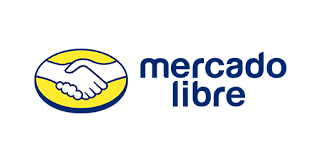


El proposito de este proyecto es entender el funcionamiento de las Redes Recurrentes.\
Variar entre RNNs y LSTM, modificar los parametros y aplicar las arquitecturas en dos diversos escenarios.

> **Para poder realizar este trabajo, es necesario comprender sobre Natural Language Processing, que nos va a permitir lidiar con strings y la conversion a un sistema que nuestras redes sean capaces de entender.**

#### Librerias

In [13]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import time

import torchtext
from torchmetrics import F1Score
from torchmetrics.classification import BinaryF1Score
from torchtext.data.utils import get_tokenizer
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error
from torchtext.vocab import Vocab
import spacy
# python -m spacy download es
from collections import Counter
from sklearn.model_selection import train_test_split

In [51]:
RANDOM_SEED=42 # try changing this to different values and see what happens to the numbers below
torch.manual_seed(seed=RANDOM_SEED)

> Links utiles

https://youtu.be/KRgq4VnCr7I

https://docs.aws.amazon.com/sagemaker/latest/dg/sms-text-classification-multilabel.html

https://towardsdatascience.com/multiclass-text-classification-using-lstm-in-pytorch-eac56baed8df

https://h-huang.github.io/tutorials/beginner/text_sentiment_ngrams_tutorial.html

http://www.cse.chalmers.se/~richajo/nlp2019/l4/Text%20classification%20using%20RNNs.html

https://towardsdatascience.com/what-is-embedding-and-what-can-you-do-with-it-61ba7c05efd8

#### DataFrame

In [52]:
dfMELI = pd.read_csv('Datasets/items_meli_proccess.csv', engine = 'python',delimiter = '␗')
dfMELI

,id,site_id,title,category_id,domain_id
0,MLA915976815,MLA,samsung galaxy a02 32 gb negro 2 gb ram,MLA1055,MLA-CELLPHONES
1,MLA1105441801,MLA,samsung galaxy a12 64 gb azul 4 gb ram,MLA1055,MLA-CELLPHONES
2,MLA1112715843,MLA,alcatel 3h 64 gb elegant black 3 gb ram,MLA1055,MLA-CELLPHONES
3,MLA929295024,MLA,moto e7 32 gb azul aqua 2 gb ram,MLA1055,MLA-CELLPHONES
4,MLA1106901282,MLA,ipro a20 dual sim 32 mb negro 32 mb ram,MLA1055,MLA-CELLPHONES
...,...,...,...,...,...
7475,MLA1112681178,MLA,audi q8 55 tfsi tiptronic quattro 340cv 2020 ...,MLA1744,MLA-CARS_AND_VANS
7476,MLA1112750522,MLA,audi q8 55 tfsi tiptronic quattro 2021 0km sin...,MLA1744,MLA-CARS_AND_VANS
7477,MLA1112719885,MLA,audi q5 2 0t fsi quattro taraborelli usados sa...,MLA1744,MLA-CARS_AND_VANS
7478,MLA1112750313,MLA,audi a6 allroad 55 tfsi quattro 340cv mild hyb...,MLA1744,MLA-CARS_AND_VANS


Conservamos las columnas relevantes y calculamos la longitud de las secuencias

In [53]:
dfMELI = dfMELI[['title', 'domain_id']]
dfMELI.columns = ['title', 'domain_id']
dfMELI['title_length'] = dfMELI['title'].apply(lambda x: len(x.split()))
dfMELI

C:\Users\Jose\AppData\Local\Temp\ipykernel_25972\156700188.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfMELI['title_length'] = dfMELI['title'].apply(lambda x: len(x.split()))


,title,domain_id,title_length
0,samsung galaxy a02 32 gb negro 2 gb ram,MLA-CELLPHONES,9
1,samsung galaxy a12 64 gb azul 4 gb ram,MLA-CELLPHONES,9
2,alcatel 3h 64 gb elegant black 3 gb ram,MLA-CELLPHONES,9
3,moto e7 32 gb azul aqua 2 gb ram,MLA-CELLPHONES,9
4,ipro a20 dual sim 32 mb negro 32 mb ram,MLA-CELLPHONES,10
...,...,...,...
7475,audi q8 55 tfsi tiptronic quattro 340cv 2020 ...,MLA-CARS_AND_VANS,9
7476,audi q8 55 tfsi tiptronic quattro 2021 0km sin...,MLA-CARS_AND_VANS,11
7477,audi q5 2 0t fsi quattro taraborelli usados sa...,MLA-CARS_AND_VANS,10
7478,audi a6 allroad 55 tfsi quattro 340cv mild hyb...,MLA-CARS_AND_VANS,10


Calculamos la longitud media del titulo para despues usarla en el encoding

In [54]:
np.mean(dfMELI['title_length'])

9.045454545454545

## El proceso de preprocessing for NLP implica:

**Tokenizar:** se define el metodo de como separar las palabras dentro un texto. Se elige el espacio, una coma, un numero?\
En nuestro caso el espacio separa las palabras

In [55]:
nlp = spacy.load("es_core_news_sm")
def tokenize(text):
    return [token.text for token in nlp.tokenizer(text)]

Realizamos un conteo de cuantas veces se utiliza cada palabra

In [56]:
# Contador
counts = Counter()
for index, row in dfMELI.iterrows():
    counts.update(tokenize(row['title']))

Borramos las palabras con frecuencia menor a 2 en todo el dataset.\
La logica es que dada su baja frecuencia, no son indicativas para ayudarnos a clasificar.

In [57]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 795
num_words after: 779


> **Creamos el vocabulario.**

Consiste en armar un array que contenga todas y cada una de las palabras/digitos o caracteres en la columna titulo.

In [58]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)
print(vocab2index)

{'': 0, 'UNK': 1, 'samsung': 2, 'galaxy': 3, 'a02': 4, '32': 5, 'gb': 6, 'negro': 7, '2': 8, 'ram': 9, 'a12': 10, '64': 11, 'azul': 12, '4': 13, 'alcatel': 14, '3h': 15, 'elegant': 16, 'black': 17, '3': 18, 'moto': 19, 'e7': 20, 'aqua': 21, 'ipro': 22, 'a20': 23, 'dual': 24, 'sim': 25, 'mb': 26, 'quantum': 27, 'five': 28, 'oro': 29, '512': 30, 'a32': 31, '128': 32, 'awesome': 33, 'nokia': 34, '106': 35, ' ': 36, '2018': 37, 'gris': 38, 'oscuro': 39, '24': 40, 'm': 41, 'carbon': 42, 'a01': 43, 'core': 44, '16': 45, '1': 46, 'kodak': 47, 'smartway': 48, 'l1': 49, 'pro': 50, 'g20': 51, 'cielo': 52, 'tcl': 53, 'l7': 54, '10': 55, 'se': 56, 'polar': 57, 'night': 58, 'zte': 59, 'blade': 60, 'a3': 61, '2020': 62, 'lg': 63, 'k61': 64, 'titanio': 65, 'k22': 66, 'titan': 67, 'k41s': 68, 'blue': 69, 'f1': 70, 'rosa': 71, 'celular': 72, 'libre': 73, '1l': 74, 'open': 75, 'techcel': 76, 'nuevo': 77, 'm12': 78, '5000': 79, 'mah': 80, 'a03s': 81, 'k52': 82, '48': 83, 'mpx': 84, 'motorola': 85, 'edge'

**Escribimos una funcion que nos permite tokenizar y encodear una frase.**

Primero tokenizamos el texto.\
Encodeamos convirtiendo cada palabra en un integer y generando un vocabulario.\
Calculamos la longitud de la frase asi podemos luego usarlo como referencia para saber en promedio cuantas palabras componen la frase.

In [59]:
def encode_sentence(text, vocab2index, N=9):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [60]:
dfMELI['encoded'] = dfMELI['title'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
dfMELI

C:\Users\Jose\AppData\Local\Temp\ipykernel_25972\26079795.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dfMELI['encoded'] = dfMELI['title'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
C:\Users\Jose\AppData\Local\Temp\ipykernel_25972\26079795.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfMELI['encoded'] = dfMELI['title'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))


,title,domain_id,title_length,encoded
0,samsung galaxy a02 32 gb negro 2 gb ram,MLA-CELLPHONES,9,"[[2, 3, 4, 5, 6, 7, 8, 6, 9], 9]"
1,samsung galaxy a12 64 gb azul 4 gb ram,MLA-CELLPHONES,9,"[[2, 3, 10, 11, 6, 12, 13, 6, 9], 9]"
2,alcatel 3h 64 gb elegant black 3 gb ram,MLA-CELLPHONES,9,"[[14, 15, 11, 6, 16, 17, 18, 6, 9], 9]"
3,moto e7 32 gb azul aqua 2 gb ram,MLA-CELLPHONES,9,"[[19, 20, 5, 6, 12, 21, 8, 6, 9], 9]"
4,ipro a20 dual sim 32 mb negro 32 mb ram,MLA-CELLPHONES,10,"[[22, 23, 24, 25, 5, 26, 7, 5, 26], 9]"
...,...,...,...,...
7475,audi q8 55 tfsi tiptronic quattro 340cv 2020 ...,MLA-CARS_AND_VANS,9,"[[723, 731, 333, 768, 624, 769, 770, 62, 110], 9]"
7476,audi q8 55 tfsi tiptronic quattro 2021 0km sin...,MLA-CARS_AND_VANS,11,"[[723, 731, 333, 768, 624, 769, 603, 583, 613]..."
7477,audi q5 2 0t fsi quattro taraborelli usados sa...,MLA-CARS_AND_VANS,10,"[[723, 729, 8, 583, 773, 774, 769, 775, 776], 9]"
7478,audi a6 allroad 55 tfsi quattro 340cv mild hyb...,MLA-CARS_AND_VANS,10,"[[723, 733, 778, 333, 768, 769, 770, 779, 780]..."


In [61]:
# Definimos las categorias y las numerizamos.
categorias = {'MLA-CELLPHONES':0, 'MLA-CELL_BATTERIES':1, 'MLA-SPEAKERS':2, 'MLA-HEADPHONES':3}
categorias

{'MLA-CELLPHONES': 0,
 'MLA-CELL_BATTERIES': 1,
 'MLA-SPEAKERS': 2,
 'MLA-HEADPHONES': 3}

In [62]:
# Manipulamos el dataframe para reemplazar los strings de categorias por sus correspondientes valores.
dfMELI = dfMELI.replace({'domain_id':categorias})
dfMELI['domain_id'].unique()

array([0, 1, 2, 3, 'MLA-POWER_CORDS', 'MLA-STREAMING_MEDIA_DEVICES',
       'MLA-SMART_SPEAKERS', 'MLA-AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS',
       'MLA-LED_CHIPS', 'MLA-TV_AND_MONITOR_MOUNTS',
       'MLA-MICROPHONE_STANDS', 'MLA-ALARM_CLOCKS',
       'MLA-ELECTRONIC_PRODUCTS', 'MLA-MICROPHONES', 'MLA-TELEVISIONS',
       'MLA-TV_RECEIVERS_AND_DECODERS',
       'MLA-TV_REPLACEMENT_BACKLIGHT_LED_STRIPS',
       'MLA-TV_REMOTE_CONTROLS', 'MLA-AM_FM_RADIOS', 'MLA-CARS_AND_VANS'],
      dtype=object)

In [63]:
dfMELI

,title,domain_id,title_length,encoded
0,samsung galaxy a02 32 gb negro 2 gb ram,0,9,"[[2, 3, 4, 5, 6, 7, 8, 6, 9], 9]"
1,samsung galaxy a12 64 gb azul 4 gb ram,0,9,"[[2, 3, 10, 11, 6, 12, 13, 6, 9], 9]"
2,alcatel 3h 64 gb elegant black 3 gb ram,0,9,"[[14, 15, 11, 6, 16, 17, 18, 6, 9], 9]"
3,moto e7 32 gb azul aqua 2 gb ram,0,9,"[[19, 20, 5, 6, 12, 21, 8, 6, 9], 9]"
4,ipro a20 dual sim 32 mb negro 32 mb ram,0,10,"[[22, 23, 24, 25, 5, 26, 7, 5, 26], 9]"
...,...,...,...,...
7475,audi q8 55 tfsi tiptronic quattro 340cv 2020 ...,MLA-CARS_AND_VANS,9,"[[723, 731, 333, 768, 624, 769, 770, 62, 110], 9]"
7476,audi q8 55 tfsi tiptronic quattro 2021 0km sin...,MLA-CARS_AND_VANS,11,"[[723, 731, 333, 768, 624, 769, 603, 583, 613]..."
7477,audi q5 2 0t fsi quattro taraborelli usados sa...,MLA-CARS_AND_VANS,10,"[[723, 729, 8, 583, 773, 774, 769, 775, 776], 9]"
7478,audi a6 allroad 55 tfsi quattro 340cv mild hyb...,MLA-CARS_AND_VANS,10,"[[723, 733, 778, 333, 768, 769, 770, 779, 780]..."


> Dropear todos los rows que tengan un string en domain id. Conservamos los integers que son las cuatro clases que vamos a utilizar a lo largo del trabajo de clasificacion.

In [64]:
dfMELI = dfMELI[dfMELI['domain_id'].astype(str).str.isdigit()]
dfMELI

,title,domain_id,title_length,encoded
0,samsung galaxy a02 32 gb negro 2 gb ram,0,9,"[[2, 3, 4, 5, 6, 7, 8, 6, 9], 9]"
1,samsung galaxy a12 64 gb azul 4 gb ram,0,9,"[[2, 3, 10, 11, 6, 12, 13, 6, 9], 9]"
2,alcatel 3h 64 gb elegant black 3 gb ram,0,9,"[[14, 15, 11, 6, 16, 17, 18, 6, 9], 9]"
3,moto e7 32 gb azul aqua 2 gb ram,0,9,"[[19, 20, 5, 6, 12, 21, 8, 6, 9], 9]"
4,ipro a20 dual sim 32 mb negro 32 mb ram,0,10,"[[22, 23, 24, 25, 5, 26, 7, 5, 26], 9]"
...,...,...,...,...
4971,auriculares philips shl5005 blanco,3,4,"[[229, 458, 549, 143, 0, 0, 0, 0, 0], 4]"
4972,pila carbon zinc aa motoma caja x 60 unids ...,1,18,"[[442, 42, 550, 258, 551, 552, 213, 212, 553], 9]"
4974,parlante philips tanx50 con bluetooth negro 10...,2,8,"[[221, 458, 566, 226, 195, 7, 567, 286, 0], 8]"
4975,pila aaa energizer max e92 cilindrica pack d...,1,10,"[[442, 209, 89, 568, 569, 446, 110, 447, 207], 9]"


## Clasificacion Binaria entre dos clases de Domain_id

> Elegimos clasificar a que clase pertenece en base a la informacion contenida en title:
> * Cellphones
> * Cell Batteries

In [65]:
dfMELI_2_clases = dfMELI[dfMELI.domain_id.isin([0, 1])].reset_index(drop=True)
dfMELI_2_clases

,title,domain_id,title_length,encoded
0,samsung galaxy a02 32 gb negro 2 gb ram,0,9,"[[2, 3, 4, 5, 6, 7, 8, 6, 9], 9]"
1,samsung galaxy a12 64 gb azul 4 gb ram,0,9,"[[2, 3, 10, 11, 6, 12, 13, 6, 9], 9]"
2,alcatel 3h 64 gb elegant black 3 gb ram,0,9,"[[14, 15, 11, 6, 16, 17, 18, 6, 9], 9]"
3,moto e7 32 gb azul aqua 2 gb ram,0,9,"[[19, 20, 5, 6, 12, 21, 8, 6, 9], 9]"
4,ipro a20 dual sim 32 mb negro 32 mb ram,0,10,"[[22, 23, 24, 25, 5, 26, 7, 5, 26], 9]"
...,...,...,...,...
2620,blister 4 pilas aa recargables scp 2700 mah,1,8,"[[435, 13, 208, 258, 210, 211, 436, 80, 0], 8]"
2621,pila aa energizer recharge nh15 2000 cilindric...,1,11,"[[442, 258, 89, 443, 444, 445, 446, 110, 447], 9]"
2622,pila 2032 5 unidades maxell,1,5,"[[442, 544, 149, 448, 545, 0, 0, 0, 0], 5]"
2623,pila carbon zinc aa motoma caja x 60 unids ...,1,18,"[[442, 42, 550, 258, 551, 552, 213, 212, 553], 9]"


In [66]:
Counter(dfMELI_2_clases['domain_id'])

Counter({0: 2500, 1: 125})

### Split del dataset en entrenamiento/test/valid.

> Data split para clasificacion de dos clases

In [67]:
x = list(dfMELI_2_clases['encoded'])
y = list(dfMELI_2_clases['domain_id'])

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x, y, test_size=0.2 )

In [68]:
class MELIdataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.x[idx][0].astype(np.int32)), self.y[idx], self.x[idx][1]

In [69]:
train_ds = MELIdataset(x_train_2, y_train_2)
test_ds = MELIdataset(x_test_2, y_test_2)

In [70]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    loss_values = []
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            #x = x.long()
            y = y.float()
            y_pred = model(x, l)
            y_pred =  torch.squeeze(y_pred)
            #print(y, y_pred,len(y),len(y_pred))
            optimizer.zero_grad()
            loss = criterion(y_pred, y)
            loss_values.append(loss.detach().numpy())
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            # item() method extracts the loss’s value as a Python float
            total += y.shape[0]
        # test_loss, test_acc, val_rmse = validation_metrics(model, val_dl)
        print("train loss %.3f" % (sum_loss/total))
        accuracy = binary_accuracy(y_pred, y)
        print("Accuracy", accuracy)
        f1 = BinaryF1Score()
        print("F1 Score: ", f1(y_pred, y))
    return loss_values

def validation_metrics (model, test_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in test_dl:
        #x = x.long()
        y = y.float()
        y_pred = model(x, l)
        y_pred =  torch.squeeze(y_pred)
        y_posta = y
    acc = binary_accuracy(y_pred, y_posta)
    print("Test ACC: ", acc)
    f1 = BinaryF1Score()
    print("Test F1 Score: ", f1(y_pred, y_posta))

In [71]:
batch_size = 500
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [72]:
class LSTM_variable_input(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        
    def forward(self, x, s):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.linear(ht[-1])
        return out

In [73]:
model = LSTM_variable_input(vocab_size, 100, 256)

In [74]:
loss_vals = train_model(model, epochs=100, lr=0.001)

train loss 0.562
Accuracy tensor(0.9700)
F1 Score:  tensor(0.5714)
train loss 0.245
Accuracy tensor(0.9800)
F1 Score:  tensor(0.5000)
train loss 0.079
Accuracy tensor(0.9600)
F1 Score:  tensor(0.)
train loss 0.041
Accuracy tensor(0.9900)
F1 Score:  tensor(0.8571)
train loss 0.021
Accuracy tensor(0.9900)
F1 Score:  tensor(0.9474)
train loss 0.014
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.011
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.009
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.007
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.005
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.004
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.002
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.002
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.001
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.001
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.002
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.001
Acc

### Dibujamos la curva de la funcion de costo de Train

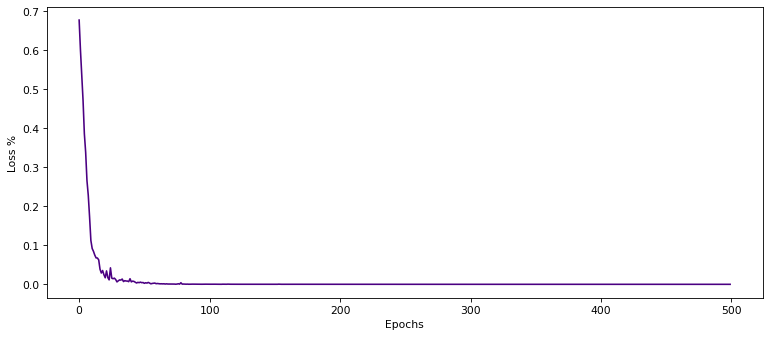

In [75]:
plt.figure(figsize=(12,5), dpi= 77)
plt.xlabel("Epochs")
plt.ylabel("Loss %")

plt.plot(loss_vals, color = 'indigo')
plt.show()

In [76]:
validation_metrics(model, test_dl)

Test ACC:  tensor(1.)
Test F1 Score:  tensor(1.)


> Nuestro primer modelo obtiene un **F1 Score de 1** cuando lo verificamos contra el test set.\
Puede ser indicativo de una gran capacidad de prediccion de la red, o de un overfitting.

### Variamos dos parámetros de la red para analizar el comportamiento y entender en que afecta la capacidad de prediccion.

> Elegimos modificar:
> * Embedding dimension: lo redujimos haciendo mas pequeno el espacio de representacion de la data.
> * Hidden dimension: aumentamos el valor para impactar en la recurrencia de la red.


In [77]:
model2 = LSTM_variable_input(vocab_size, 50, 512)

In [78]:
loss_vals2 = train_model(model2, epochs=100, lr=0.001)

train loss 0.532
Accuracy tensor(0.9500)
F1 Score:  tensor(0.)
train loss 0.147
Accuracy tensor(0.9500)
F1 Score:  tensor(0.)
train loss 0.053
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.027
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.018
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.010
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.004
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.003
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.001
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.000
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.000
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.000
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.000
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.000
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.000
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.000
Accuracy tensor(1.)
F1 Score:  tensor(1.)
train loss 0.000
Accuracy tensor(1.)
F1 Score:  

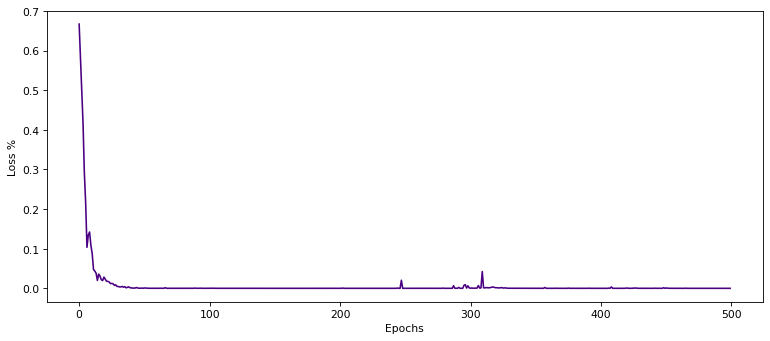

In [81]:
plt.figure(figsize=(12,5), dpi= 77)
plt.xlabel("Epochs")
plt.ylabel("Loss %")

plt.plot(loss_vals2, color = 'indigo')
plt.show()

In [82]:
validation_metrics(model2, test_dl)

Test ACC:  tensor(1.)
Test F1 Score:  tensor(1.)


> Aun variando valores de la red, el F1 Score continua en 1.

### Métricas utilizaría para medir objetivamente la performance del modelo?

##### Realizamos un Counter para poder entender como se distribuye nuestras clases. Claramente hay una skewness que impide tomar objetivamente el accuracy como indicar.\
Por eso utilizamos el **F1 Score** como indicador. Se calcula en base a la Precision y el Recall.

> **Recall**: Es la habilidad del modelo de encontrar todos los casos relevantes. Matematicamente, definimos recall como el numero de true positives, dividido por el number de True Positives mas el numero de False Negatives.\
> **Precision**: La habilidad del modelo de clasificacion para clasificar solo los data points relevantes.\ Matematicamente la precision representa el numero de True Positives dividido sobre True Positives mas el numbero de False Positives.\
> **F1 score**: Es la media armónica de precisión y el recall. Matematicamente es:\

F1 = 2 x Recall x Precision / Recall + Precision

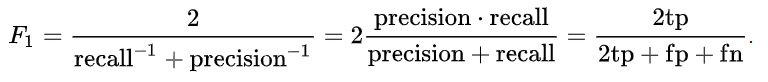

## Clasificacion entre cuatro clases de Domain_id

> Elegimos clasificar a que clase pertenece en base a la informacion contenida en title:
> * Cellphones
> * Cell Batteries
> * Speakers
> * Headphones

In [82]:
dfMELI_4_clases = dfMELI[dfMELI.domain_id.isin([0,1,2,3])].reset_index(drop=True)
dfMELI_4_clases

,title,domain_id,title_length,encoded
0,samsung galaxy a02 32 gb negro 2 gb ram,0,9,"[[2, 3, 4, 5, 6, 7, 8, 6, 9], 9]"
1,samsung galaxy a12 64 gb azul 4 gb ram,0,9,"[[2, 3, 10, 11, 6, 12, 13, 6, 9], 9]"
2,alcatel 3h 64 gb elegant black 3 gb ram,0,9,"[[14, 15, 11, 6, 16, 17, 18, 6, 9], 9]"
3,moto e7 32 gb azul aqua 2 gb ram,0,9,"[[19, 20, 5, 6, 12, 21, 8, 6, 9], 9]"
4,ipro a20 dual sim 32 mb negro 32 mb ram,0,10,"[[22, 23, 24, 25, 5, 26, 7, 5, 26], 9]"
...,...,...,...,...
3384,auriculares philips shl5005 blanco,3,4,"[[229, 458, 549, 143, 0, 0, 0, 0, 0], 4]"
3385,pila carbon zinc aa motoma caja x 60 unids ...,1,18,"[[442, 42, 550, 258, 551, 552, 213, 212, 553], 9]"
3386,parlante philips tanx50 con bluetooth negro 10...,2,8,"[[221, 458, 566, 226, 195, 7, 567, 286, 0], 8]"
3387,pila aaa energizer max e92 cilindrica pack d...,1,10,"[[442, 209, 89, 568, 569, 446, 110, 447, 207], 9]"


In [83]:
Counter(dfMELI_4_clases['domain_id'])

Counter({0: 2500, 1: 125, 2: 278, 3: 486})

In [129]:
x4 = list(dfMELI_4_clases['encoded'])
y4 = list(dfMELI_4_clases['domain_id'])

x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(x4, y4, test_size=0.2) 

In [130]:
train_ds4 = MELIdataset(x_train_4, y_train_4)
test_ds4 = MELIdataset(x_test_4, y_test_4)

In [131]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train_model4(model4, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    criterion = nn.CrossEntropyLoss()
    loss_values4 = []
    for i in range(epochs):
        model4.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl4:
            x = x.long()
            y = y.long()
            y_pred = model4(x, l)
            y_pred =  torch.squeeze(y_pred)
            print(y, y_pred,len(y),len(y_pred))
            optimizer.zero_grad()
            loss = criterion(y_pred, y)
            loss_values4.append(loss.detach().numpy())
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            # item() method extracts the loss’s value as a Python float
            total += y.shape[0]
        # test_loss, test_acc, val_rmse = validation_metrics(model, val_dl)
        print("train loss %.3f" % (sum_loss/total))
        #accuracy = binary_accuracy(y_pred, y)
        #print("Accuracy", accuracy)
        #f1 = BinaryF1Score()
        #print("F1 Score: ", f1(y_pred, y))
    return loss_values4

def validation_metrics4(model4, test_dl4):
    model4.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in test_dl4:
        x = x.long()
        y = y.long()
        y_pred = model4(x, l)
        y_pred =  torch.squeeze(y_pred)
        y_posta = y
    #acc = binary_accuracy(y_pred, y_posta)
    #print("Test ACC: ", acc)
    #f1 = BinaryF1Score()
    #print("Test F1 Score: ", f1(y_pred, y_posta))

In [168]:
class LSTM_variable_input4(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 256)
        self.fc2 = nn.Linear(256, 4)
        
    def forward(self, x, s):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.fc1(ht[-1])
        sigmoid = nn.Sigmoid()
        out = sigmoid(out)
        out = self.fc2(out)
        return out

In [169]:
batch_size = 500
vocab_size = len(words)
train_dl4 = DataLoader(train_ds4, batch_size=batch_size, shuffle=True)
test_dl4 = DataLoader(test_ds4, batch_size=batch_size)

In [170]:
model4 = LSTM_variable_input4(vocab_size, 100, 512)

In [177]:
loss_vals4 = train_model4(model4, epochs=10, lr=0.1)

tensor([0, 0, 0, 2, 2, 0, 0, 3, 0, 3, 2, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        3, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 3, 0, 0, 3, 0, 2, 0, 0, 3, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0,
        3, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 3, 0, 2, 0, 3, 2, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 3, 3, 2, 0, 0,
        0, 3, 3, 0, 2, 3, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0,
        3, 3, 0, 3, 0, 0, 0, 3, 2, 0, 0, 2, 0, 0, 0, 3, 0, 0, 1, 0, 0, 2, 0, 0,
        0, 0, 0, 0, 3, 0, 3, 1, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
        0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 3,

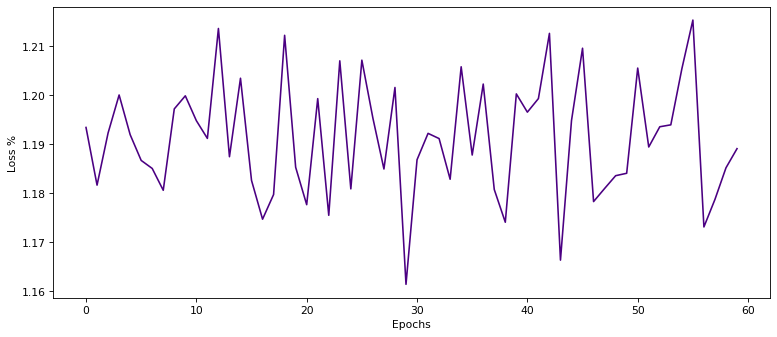

In [178]:
plt.figure(figsize=(12,5), dpi= 77)
plt.xlabel("Epochs")
plt.ylabel("Loss %")

plt.plot(loss_vals4, color = 'indigo')
plt.show()

> Al abandonar una clasificacion binaria y volverse un multiclass classification problem, hay algo de la arquitectura de la red que no nos permite abandonar la linealidad.\
El modelo no puede ir ajustando a lo largo del entrenamiento.